# CMSC422 Final Project - Exploring Diabetes
Group Members: Evan McClintock (117278590), Aniket Narkhede (117281545), Ananya Nadig (117211894)

# Introduction and Motivation
For this project, we used a [Diabetes prediction dataset from Kaggle](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset?resource=download). This dataset comprises medical and demographic data of different patients and their diabetes status. It is intended for professionals who are trying to identify patients that may have diabetes based on certain traits. Diabetes is a condition where an individual's body is either unable to properly make insulin or their body cannot use the insulin efficiently. According to the CDC, diabetes affects more than 37 million people in the US and over a third of adults are prediabetic.

Our motivation for modeling this dataset, is to help predict diabetes in patients without testing them (and to discover in general which features are more common in diabetic patients). With this knowledge, early detection/prevention and proper care for diabetes could be made possible.

A secondary motivation, specific to this project, is to compare the effectiveness of different ML techniques (DT, KNN, LR, NN, etc). While we've discussed the use cases of these models in class, we haven't spent much time comparing their effectiveness (in both prediction and resource usage) or accuracy type on a specific dataset (true/false positives/negatives). Using our knowledge from CMSC422 and pitting these models against each other, we hope to gain further insight into their advantages/disadvantages which could help us deepen our understanding and progress our careers.

The dataset contains ~100000 observations with:
- 4 continuous featuers (age, BMI, HB1AC level, and blood glucose level)
- 1 nominal feature (smoking history)
- 3 binary features (hypertension, heart disease, and gender)

which we will use to create multiple binary classification models.

# Data Wrangling & Cleaning

### Libraries
We started by importing all the libraries that are required for our project. The libraries we primarily used for the classification and analysis aspects our project was [sklearn](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). With this library, we were also able to find accuracies and confusion matrices that showed us how well our models were performing so that we could tune the parameters. We used [pandas](https://pandas.pydata.org/pandas-docs/version/1.5.2/reference/index.html#api) to read in the data and create a dataframe for our data. For further analysis and plots to show the performance of our model, we used [matplotlib](https://matplotlib.org/stable/api/index), and [numpy](https://numpy.org/doc/stable/reference/index.html#reference). 
The datafile was given in the format of a csv called ```diabetes_prediction_dataset.csv``` that we then read into a dataframe using the Pandas function ```.read_csv()```. The format of the dataframe allows us to analyze and manipulate the data.


In [ ]:
%%capture --no-display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn import ensemble
from sklearn import model_selection
from sklearn import neighbors
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
import copy
import graphviz

#Used for printing in bold
BOLD = '\033[1m'
END = '\033[0m'

# reading in the csv
path = "diabetes_prediction_dataset.csv"
df_raw = pd.read_csv(path, dtype = {'gender':'string', 'smoking_history':'string'})

# if you are running this on google colab:
# put the csv file in the content folder on the left
# df = pd.read_csv("/content/diabetes_prediction_dataset.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Preprocessing


In [ ]:
df_pre = df_raw

# There are 18 'Other' entries for gender; may as well discard since we have ~100000 rows total
df_pre = df_pre.loc[df_pre['gender'] != 'Other']
# print(df['gender'].value_counts())

# BTW: smoking_history has 6 categories. In order from least to most harmful: 'Never', 'Former', 'Not current', 'Current', 'Ever', 'No Info'

In [ ]:
# Data types
print(BOLD + "======== Data columns/types ========" + END)
print(df_pre.dtypes)
print(BOLD + "====================================" + END)

======== Data columns/types ========
gender                  string
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         string
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object


Our preprocessing includes scaling the data using the ```MinMaxScaler()``` from the scikit-learn library. We found that this form of scaling leads to less outliers due to the fixed range from 0 to 1. The featuers we scaled were age, bmi, HbA1c_level, and blood_glucose_level. We then performed one-hot encoding on the categorical features, which was gender and smoking_history. We dropped missing values, which was roughly 0.018% of the dataset. 

In [ ]:
# Preprocessing
df = df_pre.copy(deep=True)
df[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']] = MinMaxScaler().fit_transform(df[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']]) #min-max scaling
df = pd.get_dummies(df, columns = ['gender', 'smoking_history']) #one hot encoding
df.drop(columns={'gender_Male', 'smoking_history_No Info'}, inplace=True) #now we have 1 for female and 0 for male, same for smoking history
display(df.sample(5))

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
81409,0.649650,0,0,0.199463,0.236364,0.272727,0,1,0,0,0,1,0
39771,0.336837,0,0,0.202031,0.454545,0.354545,0,0,0,0,1,0,0
23428,0.024024,0,0,0.056256,0.454545,0.022727,0,1,0,0,0,0,0
58071,0.111612,0,0,0.091970,0.418182,0.340909,0,0,0,0,0,0,0
96316,0.799800,0,0,0.372549,0.181818,0.545455,0,0,0,0,0,1,0


# Systematic Modeling Procedure
We've chosen three models for our dataset: Decision Trees (DT), K Nearest Neighbors (KNN), and Neural Networks (NN). These choices cover a large range of architectures, and hopefully will gain us substantial insight into the dataset and model usage cases.

For each model, we will perform a few common steps to make the best comparisons. We'll:

1. Briefly cover how the model works
1. Construct arrays of these models by varying their respective hyperparameters
1. Evaluate the models on our dataset, plotting accuracy vs hyperparameter
1. Choose the best hyperparameter, and display this best model's confusion matrix

### Helper functions
Helper functions are incredibly useful for automating different but related tasks, like training and testing various SKLearn models. While SKLearn has a [few functions](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) for automating the training and testing of models, they are not editable to include otherwise abscent functionality. We opted to mold our own helper functions to our specific needs (for example, running a specific model train/test multiple times on different permutations of the data to smooth out our accuracy curves).

In [ ]:
# Function to repeatedly train and test the given model multiple times for different hyperparameters and return accuracy measures
# model_arr is array of type tuple(model,label) and contains the different models (with differeny HPs) to train/test
# data_init: diabetes dataframe
# iters: number of times to train/test each model - averaging accuracy
# test_size: fraction of data to split off for testing
# data_size: fraction of the data to train/test on in the first place (can be smaller than 1.0 to save time)
def train_test_repeat(model_arr, data_init, iters, test_size=0.2, data_size=1.0):
    sample_number = int(data_size * data_init.shape[0]) #how many examples to use from the dataframe
    data_arr = [(data_init.sample(sample_number), np.random.randint(low=1)) for j in range(iters)] #data and random seed for each iteration
    # (this ensures consistency throughout testing)
    train_results = np.zeros(len(model_arr))
    test_results = np.zeros(len(model_arr))
    print("===== Training/testing {:d} models {:d} times on {:d}% of data ({:d} examples) =====".format(len(model_arr), iters, int(data_size*100), sample_number))
    for i in range(len(model_arr)): #train/test every model
        train_accuracy = 0.0
        test_accuracy = 0.0
        for j in range(iters): #train/test each model multiple times and average results
            model,label = model_arr[i]
            df_small, seed = data_arr[j]
            X = df_small.drop(columns='diabetes')
            y = df_small['diabetes']
            # split train/test data
            X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state = seed)
            model.fit(X_train, y_train) #train model
            train_accuracy += model.score(X_train,y_train) #score model
            test_accuracy += model.score(X_test,y_test) #score model
        train_results[i] = train_accuracy / iters #average scores
        test_results[i] = test_accuracy / iters #average scores
        print("Model {:d} \t\tavg train accuracy= {:.5f}\t\tavg test accuracy= {:.5f}".format(i+1, train_results[i], test_results[i]))
    return train_results,test_results

In [ ]:
# Function to plot accuracy vs hyperparameter changes
# x_arr: array of hyperparameters used (used for x-axis)
# model_train: training accuracy scores
# model_test: testing accuracy scores
def plot_acc(x_arr, model_train, model_test, xlabel='Hyperparameter', title='Model Accuracy vs Parameter change'):
    plt.figure(figsize=(12,5))
    plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.plot(x_arr, model_train, color='red', label='Training accuracy') #plot training accuracy
    plt.plot(x_arr, model_test, color='blue', label='Testing accuracy') #plot testing accuracy
    plt.grid()
    plt.legend()
    plt.show()

In [ ]:
# Function to display the confusion matrix of a model
# model: any SKLearn model
# X/y_train/test: train and test sets to evaluate model on (should be the same that the model was trained on)
def disp_confusion_arr(model, X_train, y_train, X_test, y_test):
    train_acc = model.score(X_train,y_train) #evaluate training accuracy
    test_acc = model.score(X_test,y_test) #evaluate testing accuracy
    print('\n' + BOLD + "Logistic regression model:\t\ttrain accuracy= {:.5f}\t\ttest accuracy= {:.5f}".format(train_acc, test_acc) + END)
    n_examples = y_test.shape[0] #total examples used in training
    display_labels=np.array(['No diabetes','Diabetes'])

    # Confusion matrix for model: shows true&false positives&negatives
    cm = metrics.confusion_matrix(y_test, model.predict(X_test), labels=model.classes_) #calculate confusion matrix
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels) #visual representation of cm
    disp.plot() #plot cm
    plt.title('Confusion Matrix')
    tp = '{:.2f}% True negatives'.format(cm[0,0]/n_examples*100) #display percentages of categories over the entire dataset
    fp = '{:.2f}% False negatives'.format(cm[1,0]/n_examples*100)
    fn = '{:.2f}% False positives'.format(cm[0,1]/n_examples*100)
    tn = '{:.2f}% True positives'.format(cm[1,1]/n_examples*100)
    plt.text(0,0.1,tp,color='black',ha='center',va='center',fontsize=10)
    plt.text(1,0.1,fn,color='white',ha='center',va='center',fontsize=10)
    plt.text(0,1.1,fp,color='white',ha='center',va='center',fontsize=10)
    plt.text(1,1.1,tn,color='white',ha='center',va='center',fontsize=10)
    plt.show()
    return disp

## KNN

KNN is a supervised learning classifier which identifies classifications by grouping an example with others that have the shortest distance to it. Since we are working with binary classification, we wanted to observe if grouping observations with similar properties would help us categorize them between “diabetes” and “not diabetes”. Thus we chose to use the KNN model.

We're use [SKLearn’s KNeighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to perform KNN:

For KNN, we need to choose what value to set for the hyperparameter, k, which represents the number of closest “neighbors” we’ll use to classify a new example. Keeping in mind that very few neighbors lead to overfitting and too many neighbors lead to underfitting, we decided to start off our procedure by finding the optimal k-value.

Here, we set the max k-value to 31, meaning we’ll be testing our k-values within the range 1-30. We start off by initializing KNN models for all odd k-values between 1 and 30. We use only odd values here, because we want there to be a definitive winning group out of an example’s k nearest neighbors. If k is even, there can be a tie between two different groups, and we want to avoid this.

In [ ]:
# set max k-value boundary
max_k = 31

#train KNN models with k-values ranging from 1-30 and store in knn_arr
knn_arr = [(neighbors.KNeighborsClassifier(n_neighbors=i), i) for i in range(1, max_k, 2)]

In [ ]:
# setting number of iterations to run and test size
# since KNN is an online algorithm, we're only using one iteration
knn_iters=1
knn_test_size=0.2. # 0.8/0.2 train/test split
knn_data_size=1.0

Using our train_test_repeat function, we run our initialized models. By plotting the results, using testing accuracy as our measure of success, we find that having the value of k being set in the range 7-9 results in the best testing accuracy. This range also contributes to a considerably low amount of overfitting.

In [ ]:
# train models in knn_arr
knn_train,knn_test = train_test_repeat(model_arr=knn_arr, data_init=df, 
                                       iters=knn_iters, test_size=knn_test_size, data_size=knn_data_size)

===== Training/testing 15 models 1 times on 100% of data (99982 examples) =====
Model 1 		avg train accuracy= 0.99916		avg test accuracy= 0.95009
Model 2 		avg train accuracy= 0.97420		avg test accuracy= 0.95879
Model 3 		avg train accuracy= 0.96963		avg test accuracy= 0.96049
Model 4 		avg train accuracy= 0.96757		avg test accuracy= 0.96174
Model 5 		avg train accuracy= 0.96646		avg test accuracy= 0.96169
Model 6 		avg train accuracy= 0.96549		avg test accuracy= 0.96109
Model 7 		avg train accuracy= 0.96477		avg test accuracy= 0.96044
Model 8 		avg train accuracy= 0.96412		avg test accuracy= 0.96069
Model 9 		avg train accuracy= 0.96339		avg test accuracy= 0.96084
Model 10 		avg train accuracy= 0.96299		avg test accuracy= 0.96079
Model 11 		avg train accuracy= 0.96237		avg test accuracy= 0.96039
Model 12 		avg train accuracy= 0.96177		avg test accuracy= 0.96009
Model 13 		avg train accuracy= 0.96157		avg test accuracy= 0.95999
Model 14 		avg train accuracy= 0.96119		avg test accuracy=

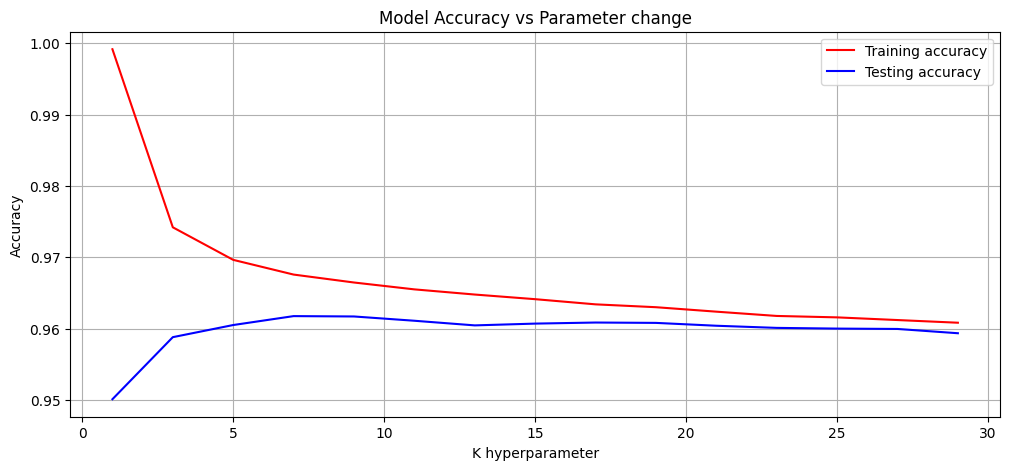

In [ ]:
# plotting the accuracy of our models based on their k-values
k_range = np.arange(1, max_k, 2)
plot_acc(k_range, knn_train, knn_test, 'K hyperparameter')

Now we know our best KNN model in terms of a good balance between testing accuracy and overfitting is one which picks a k-value from the range 7-9. Using one of these models, our next step is to create a confusion matrix which helps us better understand our model’s accuracy in terms of false positive and false negative classifications

In [ ]:
ind = np.argmax(knn_test)  # uses the k-value resulting in the highest test accuracy for our best KNN model
print('Best k param= {:d}'.format(k_range[ind]))

X = df.drop(columns='diabetes')
y = df['diabetes']
# retraining our best model
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=knn_test_size, random_state=1)
best_knn_model = neighbors.KNeighborsClassifier(n_neighbors=k_range[ind]).fit(X_train,y_train)
test_accuracy = best_knn_model.score(X_test,y_test)
print('Model accuracy= {:.5f}'.format(test_accuracy))

Best k param= 7
Model accuracy= 0.96169


Now we know our best KNN model in terms of a good balance between testing accuracy and overfitting is one which picks a k-value from the range 7-9. Using one of these models, our next step is to create a confusion matrix which helps us better understand our model’s accuracy in terms of false positive and false negative classifications

Using our disp_confusion_arr helper function, we use a confusion matrix for this model which shows us our percentages of false positives and false negatives.


Logistic regression model:		train accuracy= 0.96806		test accuracy= 0.96169


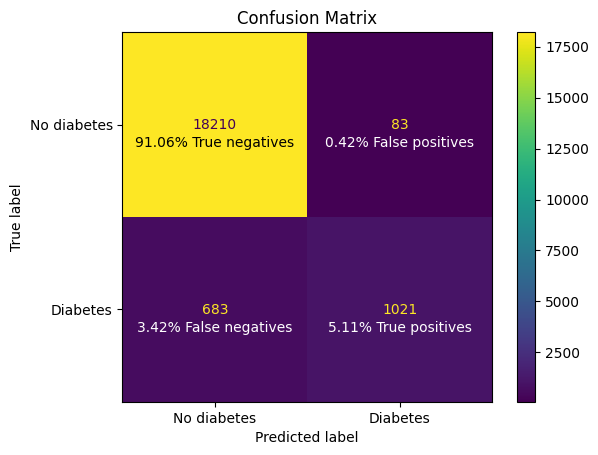

In [ ]:
knn_disp = disp_confusion_arr(best_knn_model, X_train, y_train, X_test, y_test)

As the confusion matrix shows us above, our KNN model was able to achieve a percentage of 91.06% on True Positives and 0.42% on True Negatives. As for its errors, we have a 3.42% rate on False Negatives and a 0.42% rate on False Positives. Going forward from here, our goal is to minimize these errors as much as we can in order to have as accurate of a model as possible. More specificaly, we'd like to see a lower number of False Negatives since in the context of diabetes, a False Negative means diagnosing someone as not diabetic when they really are.

After performing our first model on the dataset, we want to compare it with other classifcation models in order to find which one works best for this dataset. In order to choose additional models, we must first know whether the data we're working with is linear or not. In order to determine this, let's run a linear regression model to see whether our data has any substantial linear correlation within it.

Here, we're using [SKLearn's Linear Regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html):

# Linear Regression

In [ ]:
# create a linear regression model
model = LinearRegression()

# add model to lin_array to be later passed into train_test_repeat
lin_arr = [(model, 1)]

In [ ]:
# set number of iterations and test size
# linear regression is not affected by number of iterations here, so we set it to 1
lin_iters=1
lin_test_size=0.2  # 0.8/0.2 train/test split
lin_data_size=1.0

In [ ]:
# train regression model
lin_train,knn_test = train_test_repeat(model_arr=lin_arr, data_init=df, 
                                       iters=lin_iters, test_size=lin_test_size, data_size=lin_data_size)

===== Training/testing 1 models 1 times on 100% of data (99982 examples) =====
Model 1 		avg train accuracy= 0.35021		avg test accuracy= 0.34444


Here we can see that our accuracies are very low when using linear regression on the dataset. This leads us to focus primarily on classification models more suitable for nonlinear data from here on out.

## Decision Tree

The next classification model we looked at were decision trees. We split the data into 70/30 using the ```model_selection.train_test_split()``` function. 

In [ ]:
X = df.drop(['diabetes'],axis=1)
y = df['diabetes']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=1)

For this, we made us of scikit-learn's [descion tree classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and experimented with different parameters to see which would result in the highest accuracy. 
First, we looked at different measures of impurity, like entropy, gini (which is the default criterion), and log loss, to find which resulted in the highest accuracy. Gini had the highest accuracy but only by a small margin.

In [ ]:
# decision tree with entroy as the measure of impurity
dt = tree.DecisionTreeClassifier(criterion="entropy",random_state=1)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9525920986831139


In [ ]:
# decision tree with gini as the measure of impurity
dt = tree.DecisionTreeClassifier(criterion="gini",random_state=1) #gini is the default for the criterion parameter
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9531255209201533


In [ ]:
# decision tree with log loss as the measure of impurity
dt = tree.DecisionTreeClassifier(criterion="log_loss",random_state=1)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9525920986831139


Next, we experimented with different max depths for the decision tree, to see what the least amount of features is needed in order to still have a high accuracy rate. We found that with a max depth of 2, there was a 97.2395% accuracy rate. This shows us that even with less features, we can still achieve a high accuracy. Upon further analysis, it can tell us which features are most important to look at to predict if a patient has diabetes or not. 

In [ ]:
dt_best = tree.DecisionTreeClassifier(criterion="gini",random_state=1, max_depth=2)
dt_best.fit(X_train, y_train)
y_pred = dt_best.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9723953992332055


In [ ]:
text_representation = tree.export_text(dt_best, feature_names=list(X), max_depth = 40)
print(text_representation)

|--- HbA1c_level <= 0.58
|   |--- blood_glucose_level <= 0.59
|   |   |--- class: 0
|   |--- blood_glucose_level >  0.59
|   |   |--- class: 1
|--- HbA1c_level >  0.58
|   |--- class: 1



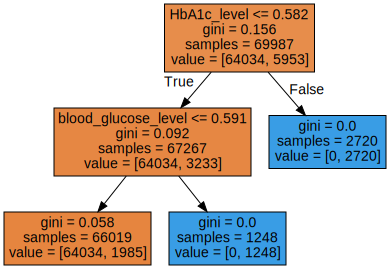

In [ ]:
# a better representation of the tree that shows the gini values at each split
dot_data = tree.export_graphviz(dt_best, out_file=None, 
                                feature_names=list(X),
                                filled=True)
graph = graphviz.Source(dot_data, format="png") 
graph

As we can see from the decision trees above that has a max depth of 2, the two features that are most important when considering if a patient has diabetes or not are HbA1c level and blood glucose level. The blue (class 1) means that a patient has diabetes, while orange (class 0) means a patient doesn't have diabetes. 

Because we had such success with decision trees, we continued to test with random forest with different measures of impurity, however, decision tree still performed a bit better. 

In [ ]:
rf = ensemble.RandomForestClassifier(n_estimators=100, criterion="entropy", random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9706951158526421


Next, we created an accuracy vs max depth chart to see how many features would need to be considered in order to still have a high accuracy. We can see around 8 features, the test accuracy begins to dip a little. This is probably [due to outliers](https://towardsdatascience.com/almost-everything-you-need-to-know-about-decision-trees-with-code-dc026172a284#:~:text=Outliers%3A%20If%20the%20tree%20is,depth%20of%20the%20tree%20increases.) in the data cause for the tree to be less accurate. 

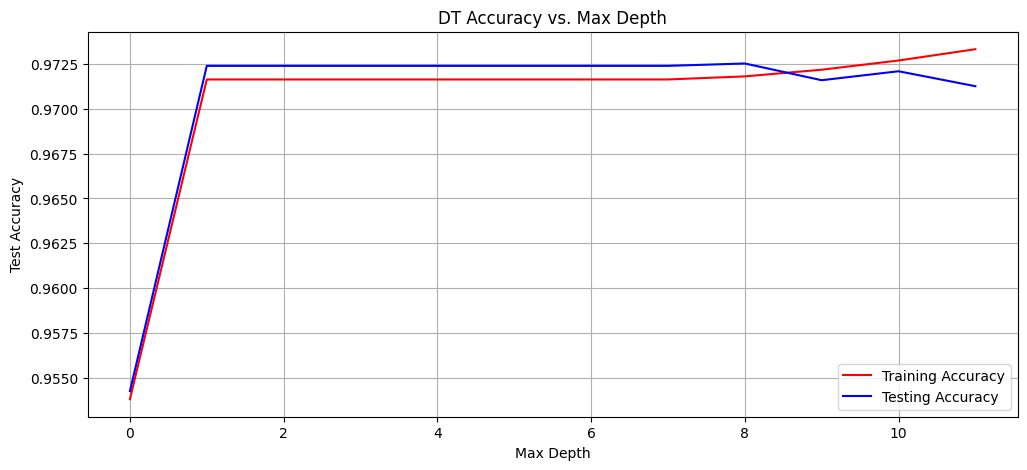

In [ ]:
max_depth_list = len(list(X))
test_err = []
train_err = []

for x in range(1, max_depth_list + 1):
    dt = tree.DecisionTreeClassifier(criterion="entropy",random_state=1, max_depth = x) 
    dt.fit(X_train,y_train)
    y_pred = dt.predict(X_test)
    y_train_pred = dt.predict(X_train)
    test_err.append(metrics.accuracy_score(y_test, y_pred))
    train_err.append(metrics.accuracy_score(y_train, y_train_pred))

#creating the graph
x = np.arange(max_depth_list)
plt.figure(figsize=(12,5))
plt.plot(x, train_err, color='red', label="Training Accuracy")
plt.plot(x, test_err, color='blue', label="Testing Accuracy")
plt.xlabel("Max Depth")
plt.ylabel("Test Accuracy") 
plt.legend()
plt.grid()
plt.title("DT Accuracy vs. Max Depth")
plt.show()

The confusion matrix below shows how well decision trees did with false negatives and false positives. One thing we observed was how there were no false negatives with decision trees and only 2.76% of false positives. 


Logistic regression model:		train accuracy= 0.97164		test accuracy= 0.97240


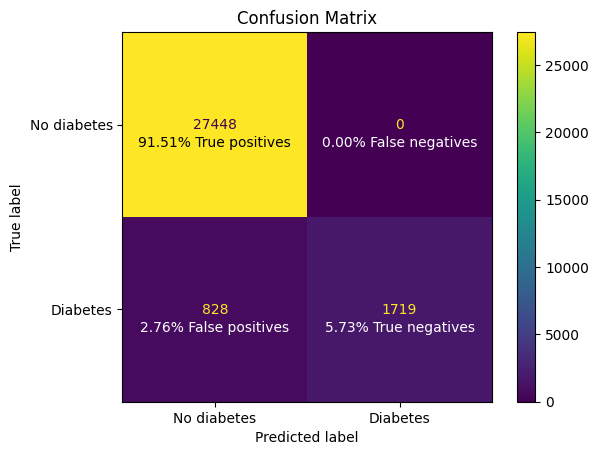

In [ ]:
dt_disp = disp_confusion_arr(dt_best, X_train, y_train, X_test, y_test)

## Neural Network

Neural networks are used in a variety of nonlinear applications, and have been especially popular in recent years in computer vision, natural language processing, and generative AI. We chose NN as our third architecture to test due to its proliferate usage rates and vital importance to the cutting edge of AI research. Here, we apply a two-layer neural network to our diabetes dataset, which acts as a **Universal Function Approximator** (*see [Ch.10 Th.10 Pg.131 in CIML](http://ciml.info/dl/v0_99/ciml-v0_99-ch10.pdf) for details*).

Specifically, we'll use SKLearn's [Multi-Layer Perceptron Classifier](https://scikit-learn.org/stable/modules/neural_networks_supervised.html) to train a network with:
- Two layers (one hidden layer): Again, two layer NN's are UFA's. Given that this dataset is on the simpler side, an excess of hidden layers isn't needed, and would make paramter tuning more labor intensive
- *Adam (adaptive moment estimation)* optimization: A [variant of SGD](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) that includes Momentum and RMS Propagation; both of these take previous gradient descent steps into account to better adapt to the objective function
- $\lambda$ = 0.0001: Regularization term that limits the size of solutions. [Occam's Razor](https://towardsdatascience.com/what-occams-razor-means-in-machine-learning-53f07effc97c) states that simpler solutions should be preferred over complex ones (all else being equal), as they are statistically more likely to generalize to new data

In [ ]:
# Initialize NN parameters
solver = 'adam' #SGD plus Momentum and RMS Prop
alpha = 0.0001 #lambda for regularization term
max_nn_units = 10 #We'll train networks with the number of hidden units varying from 1 to 10

We'll vary the number of hidden units used in the NN models, and evaluate how they perform on our dataset. Since we have 8 feature values, we'll use unit values up to 2 above that number (10).

In [ ]:
# Here we create the array of NNs (with different numbers of hidden units) to be trained and tested
nn_arr = [(MLPClassifier(solver=solver, alpha=alpha, hidden_layer_sizes=(i,)), '1 layer, {:d} units'.format(i)) for i in range(1,max_nn_units+1)]

In [ ]:
# Train and test NN models
nn_iters=3 #train/test each NN model 3 times and average over the 3 trials
nn_test_size=0.2 #80/20 train/test split
nn_data_size=0.2 #only use 20% of dataset (~20000) for training to save time - we can evaluate the final model on the full dataset later
nn_train,nn_test = train_test_repeat(nn_arr, data_init=df, 
                                     iters=nn_iters, test_size=nn_test_size, data_size=nn_data_size) #train/test models

===== Training/testing 10 models 3 times on 20% of data (19996 examples) =====
Model 1 		avg train accuracy= 0.92942		avg test accuracy= 0.93292
Model 2 		avg train accuracy= 0.94588		avg test accuracy= 0.94458
Model 3 		avg train accuracy= 0.96037		avg test accuracy= 0.95908
Model 4 		avg train accuracy= 0.96055		avg test accuracy= 0.95958
Model 5 		avg train accuracy= 0.96051		avg test accuracy= 0.95992
Model 6 		avg train accuracy= 0.96057		avg test accuracy= 0.95925
Model 7 		avg train accuracy= 0.96028		avg test accuracy= 0.95975
Model 8 		avg train accuracy= 0.96066		avg test accuracy= 0.95925
Model 9 		avg train accuracy= 0.96062		avg test accuracy= 0.95958
Model 10 		avg train accuracy= 0.96022		avg test accuracy= 0.95925


Now we can plot the final training and test accuracy for each of our models; we end up with an Accuracy vs Hidden Units graph that shows the marginal improvement of the model from adding each hidden neuron.

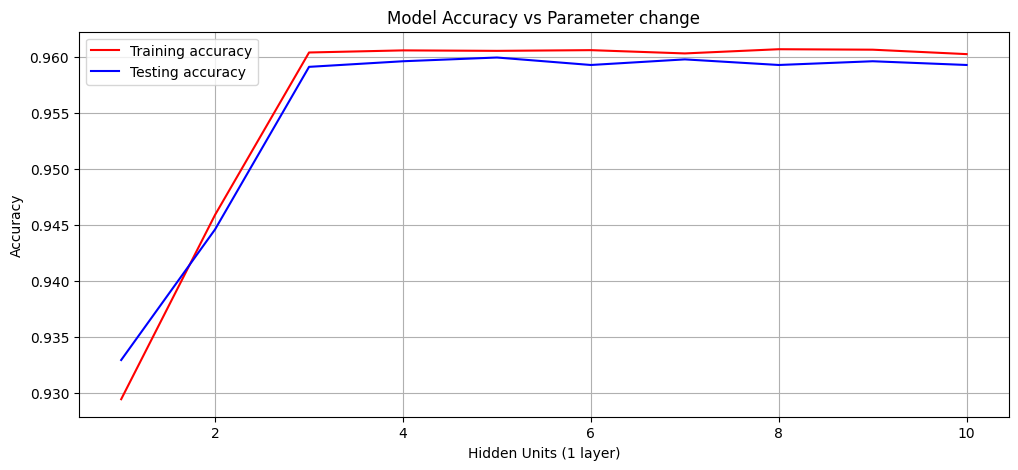

In [ ]:
# Plot model accuracy vs units in model
units_arr = np.arange(1,max_nn_units+1,1)
plot_acc(units_arr,nn_train,nn_test)

As seen above, the training and testing accuracy follow each other closely. This is good evidence that the NN model is [generalizing well](https://datascience.stackexchange.com/questions/42606/validation-accuracy-is-always-close-to-training-accuracy) (if it was overfitting, we'd see higher training than test accuracy), aka it has low variance (properly tuned hyperparameters).

NN are typically prone to overfitting since they're more complex but need attention to HP tuning (see [CMSC422 Lecture 15 Pg.30](https://umd.instructure.com/courses/1338848/files/folder/Lectures?preview=72686162)); this often leads to a low bias (fundamental model error) but high variance (HP estimation error). In our case, we actually find low variance, which is a good sign that the model is not *too* complex for the dataset. Had we included more layers, we might have found a tendency to overfit.

While the single hidden layer is likely a large contributing factor to the low overfitting, the lambda regularizer almost certainly played a large role in preventing overfitting.

Since the accuracy improves minimally after the 3rd hidden neuron is added, we will take this 2-layer 3-node NN to be the best model for our dataset. Below, we reproduce this model and train it on *100%* of the data to get a more precise estimate of it's accuracy (which we can efficientlly do, now that we don't have to run 10 models at a time).

In [ ]:
ind = 2 #index of model with 3 hidden units
print('Best unit param= {:d}'.format(units_arr[ind]))

# Re-train 3-unit model on the entire dataset
X = df.drop(columns='diabetes')
y = df['diabetes']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=nn_test_size, random_state=1)
best_nn_model = MLPClassifier(solver=solver, alpha=alpha, hidden_layer_sizes=(units_arr[ind],)).fit(X_train,y_train)
test_accuracy = best_nn_model.score(X_test,y_test)
print('Model accuracy= {:.5f}'.format(test_accuracy))

Best unit param= 3
Model accuracy= 0.96054



Logistic regression model:		train accuracy= 0.96044		test accuracy= 0.96054


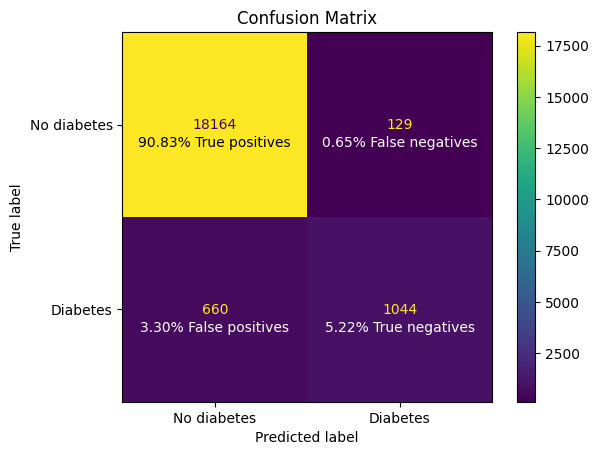

In [ ]:
# We show the confusion matrix for this model
nn_disp = disp_confusion_arr(best_nn_model, X_train, y_train, X_test, y_test)

As shown in the confusion matrix, while most (96.054%) of examples are classified correctly, we do have some misclassifications. Specifically, out of the 3.95% of mislabels, most (3.30%) were false positives and a minority (0.65%) were false negatives. This is a similar pattern to the previous two models, and most likely reflects properties of the dataset (many more negatives than positives) than properties of the NN model.

# Wrap Up

### Conclusion
Overall, our three models did very well in themselves. KNN had an accuracy of 96.3361%, Decision Tree was 97.2395%, and Neural Network was 97.0102%. Given the low amounts of error, we see that the data has many separable patterns that allow it to be (relatively) easily classified.

The Decision Tree model had the best performance by a slim margin and was actually the [least computationally expensive](https://stats.stackexchange.com/questions/294033/why-are-decision-trees-not-computationally-expensive) to implement (as it utilizes a greedy approach). However, the other model implementations gave good insight into the structure of the data and how 'well-suited' the dataset was for each model. For example, we saw that NN had similar training and testing accuracies across all hyperparameters, indicating that it was not and overly complicated model for the dataset (or, conversely, that the dataset was well distributed for use in a two-layer NN). We also saw that 7-9 neighbors was almost always sufficient for the ideal classification accuracy, despite the enormous ~100000 size of the dataset. DT in particular helped us deduce the two most important features for diabetes classification: HB1AC level, and blood glucose level.

While imperfect, these models show huge potential for the automatic prediction of diabetes in patients across a wide array of ages and body types; they could easily be used in medical screenings to assist a doctor in diagnosing diabetes. They also offer insight into the patterns underlying the presence of diabetes; namely, they point out a strong correlation between HB1AC levels/blood glucose levels, and whether or not a patient has diabetes. While we are not medical students, this is undoubtedly an important piece of information in the study of diabetes, and likely represents a more fundamental aspect of [the endocrine system](https://www.carenewengland.org/blog/endocrine-system-and-diabetes#:~:text=Diabetes%20is%20the%20most%20common,1%20or%20Type%202%20diabetes.).

### Future Work
For one, we could look into dimensionality reduction techniques like [PCA](https://builtin.com/data-science/step-step-explanation-principal-component-analysis) to see which features are most important. Above, the Decision Tree showed us that only two features were majorly important, despite having access to 8 total. This could imply that even though the dataset is of dimension D=8, it could be reduced to d=2 or d=3. Other techniques to accomplish this dimensionality reduction include [Kernels and Autoencoders](https://towardsdatascience.com/dimensionality-reduction-pca-versus-autoencoders-338fcaf3297d); they are designed to capture non-linear patterns during dimensionality reduction, which could be useful for our dataset.

The other major question we want to look into is: is there a particular aspect of this dataset that set up KNN to perform poorer than DT and NN? This is an extension of our original question: which ML architectures will work best to model our dataset, and with what hyperparameters? For example, we found that DT was best suited to our data (out of the models we chose to implement), indicating that the data might be distributed about a [decision boundary](https://medium.com/analytics-vidhya/decision-boundary-for-classifiers-an-introduction-cc67c6d3da0e) simple enough for a depth-2 decision tree to accurately model. This is an important insight, but it doesn't provide a full explanation as to why KNN did not achieve the same level of accuracy. However, this exploration could be furthered through the use of other model types (like [Naive Bayes](https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c), a probability-based classifier), deeper exploration into the decision boundary of the dataset, and visualization of our important features/labels.

Overall, this project was a big success, and an important lesson in the selection and implementation of various Machine Learning architectures. In addition to learning more about Decision Tree, KNN, and Neural Network models, we gained intuition as to how these models are best initialized/trained for particular amounts of data and best practices to properly and efficiently utilize them (for example, neural networks take large amounts of time to train, forcing you to allocate time efficiently to tune hyperparameters and make use of knowledge from past runs). The experience from this project will be valuable as we refine our career interests, improve our ML coding skills, and continue our journey of data-exploration and modeling in the real world.